<a href="https://colab.research.google.com/github/EnriqueAlfaro77/telecomx_parte2/blob/main/telecomx_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import requests

# 1. Cargar JSON desde la URL
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
data = requests.get(url).json()

# 2. Normalizar el JSON anidado
df = pd.json_normalize(data)

# 3. Renombrar columnas
df.rename(columns=lambda x: x.replace('.', '_').lower(), inplace=True)

# 4. Limpieza de columnas binarias
cols_binarias = [
    'churn',
    'customer_partner',
    'customer_dependents',
    'phone_phoneservice',
    'account_paperlessbilling'
]
for col in cols_binarias:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# 5. Eliminar valores nulos en churn
df = df.dropna(subset=['churn'])

# 6. Codificación de otras columnas
# Género
df['customer_gender'] = df['customer_gender'].map({'Male': 1, 'Female': 0})
# Servicio de internet
df['internet_internetservice'] = df['internet_internetservice'].map({
    'No': 0,
    'DSL': 1,
    'Fiber optic': 2
})
# Contrato simple
df['account_contract_simple'] = df['account_contract'].map({
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
})

# 7. Unificar valores de servicio
cols_servicio = [
    'phone_multiplelines',
    'internet_onlinesecurity',
    'internet_onlinebackup',
    'internet_deviceprotection',
    'internet_techsupport',
    'internet_streamingtv',
    'internet_streamingmovies'
]
for col in cols_servicio:
    df[col] = df[col].replace(['No internet service', 'No phone service'], 'No')

# 8. Conversión a float
df['account_charges_total'] = pd.to_numeric(df['account_charges_total'], errors='coerce')

# 9. Crear columna cuentas_diarias
df['account_cuentas_diarias'] = df['account_charges_monthly'] / 30


In [4]:
# 1) Asegurar numéricas clave
num_cols = [
    'account_charges_monthly',
    'account_charges_total',
    'customer_tenure'  # ajusta al nombre real: ej. 'customer_tenure_months'
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 2) Mapear Yes/No -> 1/0 en servicios
cols_yesno = [
    'phone_multiplelines',
    'internet_onlinesecurity',
    'internet_onlinebackup',
    'internet_deviceprotection',
    'internet_techsupport',
    'internet_streamingtv',
    'internet_streamingmovies'
]
for c in cols_yesno:
    if c in df.columns:
        df[c] = df[c].map({'Yes': 1, 'No': 0})

# 3) One-hot para categóricas restantes (ejemplos comunes)
cats = []
for candidate in ['account_paymentmethod', 'account_contract']:
    if candidate in df.columns:
        cats.append(candidate)

df = pd.get_dummies(df, columns=cats, drop_first=True)

# 4) Feature opcional: conteo de servicios activos
servicios_bin = [c for c in cols_yesno if c in df.columns]
if 'phone_phoneservice' in df.columns:
    servicios_bin.append('phone_phoneservice')
df['total_servicios'] = df[servicios_bin].sum(axis=1)

# 5) Recalcular cuentas_diarias si falta y manejar nulos obvios
if 'account_charges_monthly' in df.columns and 'account_cuentas_diarias' not in df.columns:
    df['account_cuentas_diarias'] = df['account_charges_monthly'] / 30

# 6) Quitar identificadores no predictivos si existen
for id_col in ['customer_id', 'customer_customerid', 'id']:
    if id_col in df.columns:
        df.drop(columns=id_col, inplace=True)

# 7) Filas sin target y limpieza final
df = df.dropna(subset=['churn'])  # target
# (opcional) imputaciones simples:
for c in num_cols:
    if c in df.columns:
        med = df[c].median()
        df[c] = df[c].fillna(med)

# 8) Guardar dataset tratado
df.to_csv('datos_tratados.csv', index=False)
print('OK -> datos_tratados.csv')

OK -> datos_tratados.csv


In [5]:
import pandas as pd

# Cargar el archivo limpio
df = pd.read_csv('datos_tratados.csv')

# Ver primeras filas
print(df.head())

# Resumen de columnas y tipos de datos
print(df.info())

# Conteo de valores nulos por columna
print(df.isnull().sum())


   customerid  churn  customer_gender  customer_seniorcitizen  \
0  0002-ORFBO    0.0                0                       0   
1  0003-MKNFE    0.0                1                       0   
2  0004-TLHLJ    1.0                1                       0   
3  0011-IGKFF    1.0                1                       1   
4  0013-EXCHZ    1.0                0                       1   

   customer_partner  customer_dependents  customer_tenure  phone_phoneservice  \
0                 1                    1                9                   1   
1                 0                    0                9                   1   
2                 0                    0                4                   1   
3                 1                    0               13                   1   
4                 1                    0                3                   1   

   phone_multiplelines  internet_internetservice  ...  \
0                  NaN                         1  ...   
1       

In [6]:
# Quitar ID
if 'customerid' in df.columns:
    df.drop(columns=['customerid'], inplace=True)

# Convertir booleanos a 0/1
df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Verificar que todo sea numérico
print(df.dtypes)

# Revisar si quedan nulos
print(df.isnull().sum())


churn                                            float64
customer_gender                                    int64
customer_seniorcitizen                             int64
customer_partner                                   int64
customer_dependents                                int64
customer_tenure                                    int64
phone_phoneservice                                 int64
phone_multiplelines                              float64
internet_internetservice                           int64
internet_onlinesecurity                          float64
internet_onlinebackup                            float64
internet_deviceprotection                        float64
internet_techsupport                             float64
internet_streamingtv                             float64
internet_streamingmovies                         float64
account_paperlessbilling                           int64
account_charges_monthly                          float64
account_charges_total          

/tmp/ipython-input-1063984202.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))


In [7]:
# Columnas con NaN que son binarias (0/1)
cols_binarias_nan = [
    'phone_multiplelines',
    'internet_onlinesecurity',
    'internet_onlinebackup',
    'internet_deviceprotection',
    'internet_techsupport',
    'internet_streamingtv',
    'internet_streamingmovies'
]

for col in cols_binarias_nan:
    df[col] = df[col].fillna(0)

# Confirmar que no haya más nulos
print(df.isnull().sum().sum())  # Debe dar 0


0


In [8]:
# Columnas binarias con NaN (representan "No" si falta el valor)
cols_binarias_nan = [
    'phone_multiplelines',
    'internet_onlinesecurity',
    'internet_onlinebackup',
    'internet_deviceprotection',
    'internet_techsupport',
    'internet_streamingtv',
    'internet_streamingmovies'
]

# Rellenar NaN con 0
for col in cols_binarias_nan:
    df[col] = df[col].fillna(0)

# Verificar que no queden nulos en todo el DataFrame
print("Nulos totales después de limpiar:", df.isnull().sum().sum())


Nulos totales después de limpiar: 0


In [9]:
# Conteo absoluto
print(df['churn'].value_counts())

# Proporción en porcentaje
print(df['churn'].value_counts(normalize=True) * 100)


churn
0.0    5174
1.0    1869
Name: count, dtype: int64
churn
0.0    73.463013
1.0    26.536987
Name: proportion, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Separar features y target
X = df.drop(columns=['churn'])
y = df['churn']

# 2. Train/Test Split (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Crear modelo de Regresión Logística con balance de clases
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 4. Entrenar
logreg.fit(X_train, y_train)

# 5. Predicciones
y_pred = logreg.predict(X_test)

# 6. Evaluación
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Matriz de confusión:
 [[1088  464]
 [ 110  451]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.91      0.70      0.79      1552
         1.0       0.49      0.80      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.80      0.73      0.74      2113



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
logreg = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import pandas as pd

# Entrenar Random Forest con balance de clases
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Métricas
print("== Random Forest ==")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_rf))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# Importancia de variables (top 10)
importancias = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 features más importantes:\n", importancias.head(10))


== Random Forest ==
Matriz de confusión:
 [[1372  180]
 [ 284  277]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.83      0.88      0.86      1552
         1.0       0.61      0.49      0.54       561

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113

ROC-AUC: 0.8155367348438907

Top 10 features más importantes:
 account_charges_total                     0.168861
customer_tenure                           0.157383
account_cuentas_diarias                   0.150457
account_charges_monthly                   0.149090
account_contract_simple                   0.098412
internet_internetservice                  0.046664
account_contract_Two year                 0.044282
account_paymentmethod_Electronic check    0.032999
account_paperlessbilling                  0.025143
customer_gender                           0.023964
dty

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# 1. Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribución original:", y_train.value_counts())
print("Distribución balanceada con SMOTE:", y_train_smote.value_counts())

# 2. Entrenar Random Forest con datos balanceados
rf_smote = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf_smote.fit(X_train_smote, y_train_smote)

# 3. Predicciones
y_pred_smote = rf_smote.predict(X_test)
y_prob_smote = rf_smote.predict_proba(X_test)[:, 1]

# 4. Evaluación
print("\n== Random Forest con SMOTE ==")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_smote))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_smote))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_smote))

# 5. Importancia de variables
importancias_smote = pd.Series(rf_smote.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 features más importantes con SMOTE:\n", importancias_smote.head(10))


Distribución original: churn
0.0    3622
1.0    1308
Name: count, dtype: int64
Distribución balanceada con SMOTE: churn
0.0    3622
1.0    3622
Name: count, dtype: int64

== Random Forest con SMOTE ==
Matriz de confusión:
 [[1249  303]
 [ 217  344]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.85      0.80      0.83      1552
         1.0       0.53      0.61      0.57       561

    accuracy                           0.75      2113
   macro avg       0.69      0.71      0.70      2113
weighted avg       0.77      0.75      0.76      2113

ROC-AUC: 0.8050350763548156

Top 10 features más importantes con SMOTE:
 account_charges_total        0.144013
customer_tenure              0.143300
account_charges_monthly      0.134572
account_cuentas_diarias      0.131499
account_contract_simple      0.126796
account_contract_Two year    0.054980
account_contract_One year    0.039570
customer_dependents          0.034442
internet_internets

churn                                            1.000000
internet_internetservice                         0.316846
account_paymentmethod_Electronic check           0.301919
account_charges_monthly                          0.193356
account_cuentas_diarias                          0.193356
account_paperlessbilling                         0.191825
customer_seniorcitizen                           0.150889
phone_phoneservice                               0.011942
total_servicios                                  0.011942
customer_gender                                 -0.008612
account_paymentmethod_Mailed check              -0.091683
account_paymentmethod_Credit card (automatic)   -0.134302
customer_partner                                -0.150448
customer_dependents                             -0.164221
account_contract_One year                       -0.177820
account_charges_total                           -0.199037
account_contract_Two year                       -0.302253
customer_tenur

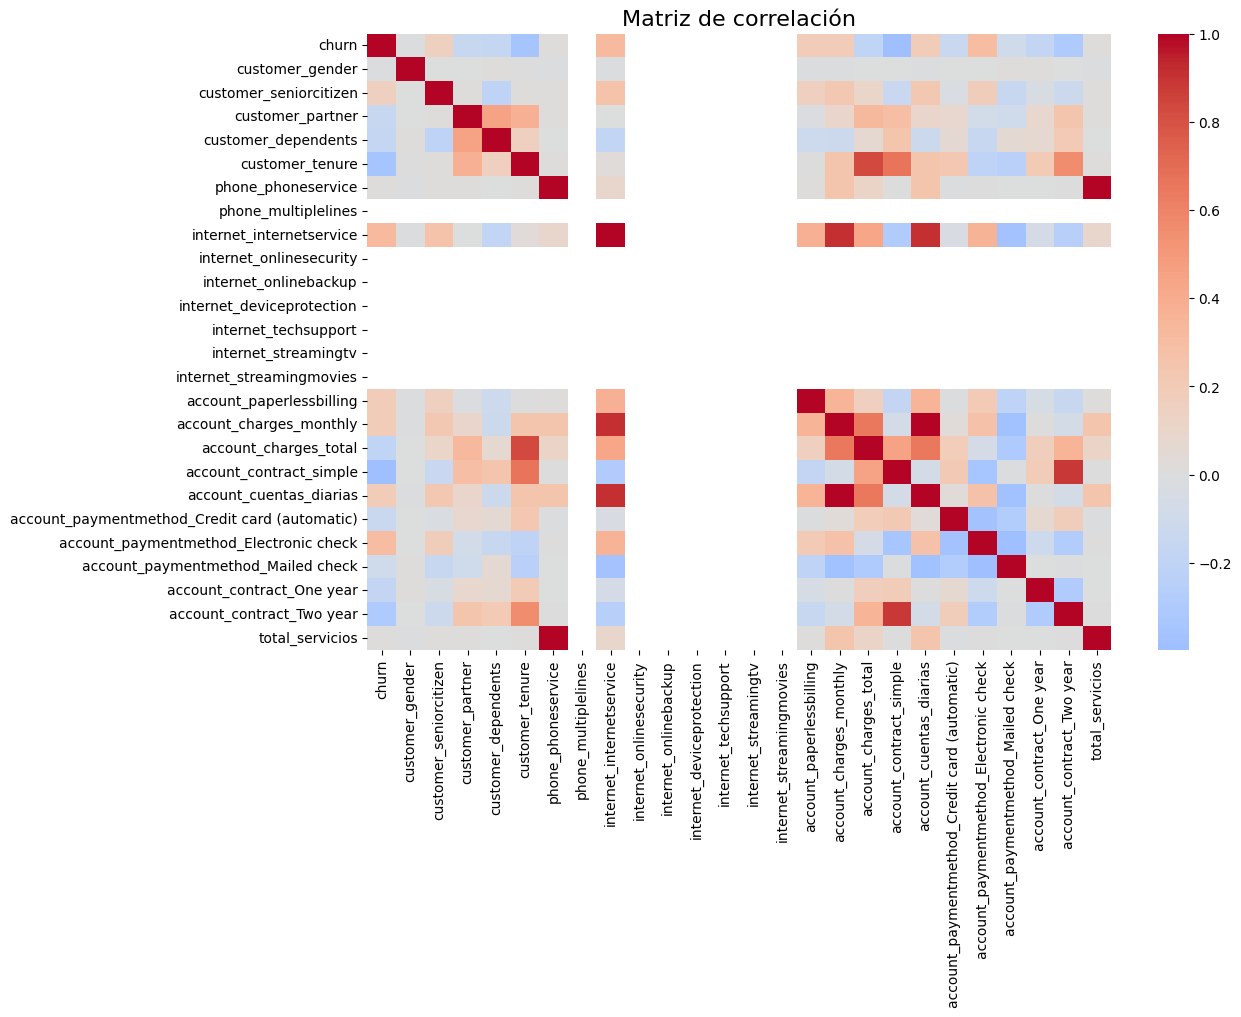

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de correlación
corr = df.corr()

# Correlaciones con churn, ordenadas
print(corr['churn'].sort_values(ascending=False))

# Visualización (opcional, más visual)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Matriz de correlación", fontsize=16)
plt.show()


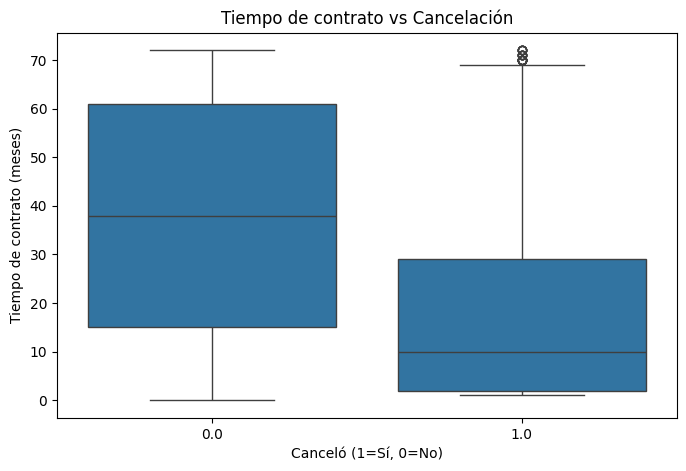

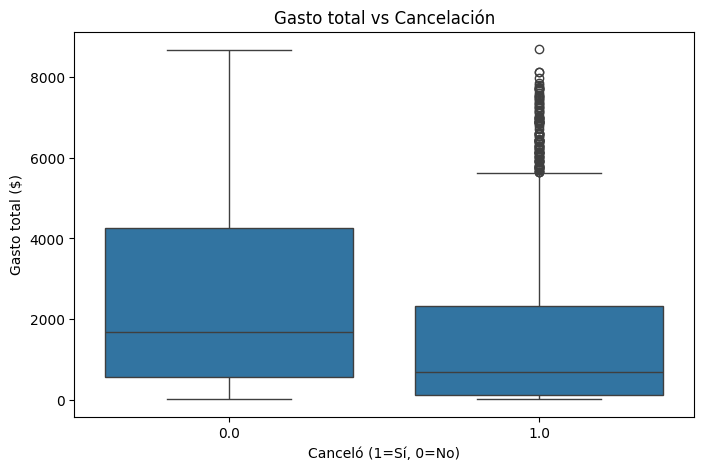

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot: Tiempo de contrato vs Cancelación
plt.figure(figsize=(8,5))
sns.boxplot(x='churn', y='customer_tenure', data=df)
plt.title('Tiempo de contrato vs Cancelación')
plt.xlabel('Canceló (1=Sí, 0=No)')
plt.ylabel('Tiempo de contrato (meses)')
plt.show()

# Boxplot: Gasto total vs Cancelación
plt.figure(figsize=(8,5))
sns.boxplot(x='churn', y='account_charges_total', data=df)
plt.title('Gasto total vs Cancelación')
plt.xlabel('Canceló (1=Sí, 0=No)')
plt.ylabel('Gasto total ($)')
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

# X = variables independientes
# y = variable objetivo (churn)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,   # 30% prueba, 70% entrenamiento
    random_state=42, # para reproducibilidad
    stratify=y       # mantiene proporción de clases
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Tamaño y_train:", y_train.shape)
print("Tamaño y_test:", y_test.shape)


Tamaño X_train: (4930, 25)
Tamaño X_test: (2113, 25)
Tamaño y_train: (4930,)
Tamaño y_test: (2113,)


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Pipeline: normalización + regresión logística
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42))
])

# Entrenar
pipe_logreg.fit(X_train, y_train)

# Predicciones
y_pred_logreg = pipe_logreg.predict(X_test)
y_prob_logreg = pipe_logreg.predict_proba(X_test)[:, 1]

# Resultados
print("=== Modelo 1: Regresión Logística (con normalización) ===")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_logreg))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_logreg))


=== Modelo 1: Regresión Logística (con normalización) ===
Matriz de confusión:
 [[1089  463]
 [ 112  449]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.91      0.70      0.79      1552
         1.0       0.49      0.80      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.80      0.73      0.74      2113

ROC-AUC: 0.8336784690446002


In [19]:
from sklearn.ensemble import RandomForestClassifier

# Modelo sin normalización
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Entrenar
rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Resultados
print("=== Modelo 2: Random Forest (sin normalización) ===")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_rf))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


=== Modelo 2: Random Forest (sin normalización) ===
Matriz de confusión:
 [[1372  180]
 [ 284  277]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.83      0.88      0.86      1552
         1.0       0.61      0.49      0.54       561

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113

ROC-AUC: 0.8155367348438907


In [20]:
# Extraer coeficientes del modelo
coeficientes = pipe_logreg.named_steps['model'].coef_[0]
variables = X_train.columns
importancia_logreg = pd.Series(coeficientes, index=variables).sort_values(key=abs, ascending=False)

print(importancia_logreg.head(10))


customer_tenure                          -1.386939
account_charges_total                     0.678542
internet_internetservice                  0.562255
account_contract_simple                  -0.369990
account_contract_Two year                -0.285568
account_paperlessbilling                  0.215626
account_paymentmethod_Electronic check    0.213769
account_contract_One year                -0.156428
customer_dependents                      -0.104835
customer_seniorcitizen                    0.096584
dtype: float64


In [21]:
importancias_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(importancias_rf.head(10))


account_charges_total                     0.168861
customer_tenure                           0.157383
account_cuentas_diarias                   0.150457
account_charges_monthly                   0.149090
account_contract_simple                   0.098412
internet_internetservice                  0.046664
account_contract_Two year                 0.044282
account_paymentmethod_Electronic check    0.032999
account_paperlessbilling                  0.025143
customer_gender                           0.023964
dtype: float64


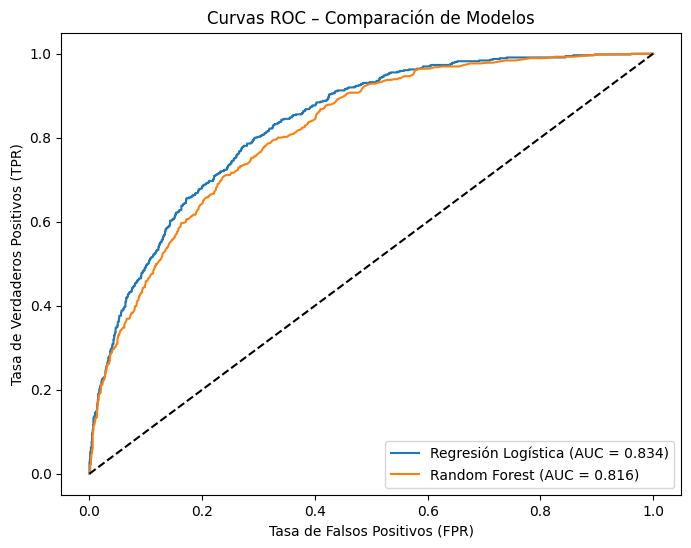

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# ==== Modelo 1: Regresión Logística ====
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_logreg)
auc_log = roc_auc_score(y_test, y_prob_logreg)

# ==== Modelo 2: Random Forest ====
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# ==== Gráfico ROC ====
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Regresión Logística (AUC = {auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0,1], [0,1], 'k--')  # línea aleatoria
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC – Comparación de Modelos")
plt.legend()
plt.show()
